# CS109A Project Milestone 4: Models
## Group 29

- Tatyana Zyabkina
- Joanna Guo
- John Liang
- Ray Ortigas

Our models are partial reproductions of the models described in the Ritter et al. 2015 paper, ["Multimodal prediction of conversion to Alzheimer’s disease based on incomplete biomarkers".](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4877756/?report=reader), with some adjustments based on experimentation.

Using the ADNIMERGE data set, we used the following process:

- Select analysis cohort, participants who completed a 36-month or later follow-up
- Identify "converters" who transitioned from non-AD to AD diagnosis sometime in the first 36 months of their study participation
- Identify features that based on our research are likely to be predictive
- Impute missing values with mean
- Dummy-encode and scale features
- Fit SVM, Random Forest, and Logistic Regression models and evaluate their predictive powers

## Styling

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import itertools
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

## Loading

In [7]:
adni_df = pd.read_csv("../data/ADNIMERGE.csv")

In [8]:
adni_df.shape

(13017, 94)

In [9]:
adni_df.head()

,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.36926,NaN,NaN,0.000000,0.00000,0,0,2017-08-13 23:50:48.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,NaN,NaN,1.09079,NaN,NaN,0.000000,0.00000,0,0,2017-08-13 23:50:48.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,...,NaN,NaN,1.09079,NaN,NaN,0.498289,5.96721,6,6,2017-08-13 23:50:48.0
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,...,NaN,NaN,1.09079,NaN,NaN,0.999316,11.96720,12,12,2017-08-13 23:50:48.0
4,3,011_S_0003,m24,11,ADNI1,ADNI1,2007-09-12,AD,81.3,Male,...,NaN,NaN,1.09079,NaN,NaN,1.998630,23.93440,24,24,2017-08-13 23:50:48.0


In [10]:
adni_df.dtypes

RID                        int64
PTID                      object
VISCODE                   object
SITE                       int64
COLPROT                   object
ORIGPROT                  object
EXAMDATE                  object
DX_bl                     object
AGE                      float64
PTGENDER                  object
PTEDUCAT                   int64
PTETHCAT                  object
PTRACCAT                  object
PTMARRY                   object
APOE4                    float64
FDG                      float64
PIB                      float64
AV45                     float64
CDRSB                    float64
ADAS11                   float64
ADAS13                   float64
MMSE                     float64
RAVLT_immediate          float64
RAVLT_learning           float64
RAVLT_forgetting         float64
RAVLT_perc_forgetting    float64
FAQ                      float64
MOCA                     float64
EcogPtMem                float64
EcogPtLang               float64
          

In [11]:
adni_df.describe()

,RID,SITE,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,...,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M
count,13017.000000,13017.000000,13017.000000,13017.000000,12958.000000,3353.000000,223.000000,2161.000000,9016.000000,8959.000000,...,5749.000000,5888.000000,6024.000000,9353.000000,148.000000,5969.000000,13017.000000,13017.000000,13017.000000,13017.000000
mean,2285.200584,73.892064,73.767220,15.994930,0.535654,1.208225,1.783161,1.195504,2.163598,11.398507,...,1.641999,1.833192,1.682636,1.248308,1.589713,1.200700,2.235266,26.768221,26.688868,26.498041
std,1871.013213,110.533877,6.979685,2.824862,0.655480,0.160972,0.422511,0.227999,2.805879,8.616859,...,0.833310,0.890230,0.695583,0.145496,0.305744,0.221538,2.225071,26.646135,26.609785,26.398907
min,2.000000,2.000000,54.400000,4.000000,0.000000,0.636804,1.095000,0.814555,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.697264,1.155000,0.838537,0.000000,0.000000,0.000000,0.000000
25%,631.000000,21.000000,69.500000,14.000000,0.000000,1.109730,1.361250,1.010140,0.000000,5.330000,...,1.000000,1.000000,1.153850,1.159220,1.360000,1.018950,0.498289,5.967210,6.000000,6.000000
50%,1301.000000,41.000000,73.700000,16.000000,0.000000,1.219870,1.850000,1.114670,1.000000,9.000000,...,1.250000,1.500000,1.421050,1.255850,1.490000,1.120310,1.524980,18.262300,18.000000,18.000000
75%,4353.000000,116.000000,78.600000,18.000000,1.000000,1.314320,2.127500,1.364980,3.000000,15.000000,...,2.000000,2.250000,2.029533,1.340630,1.835000,1.374980,3.091030,37.016400,36.000000,36.000000
max,6094.000000,941.000000,91.400000,20.000000,2.000000,1.753320,2.927500,2.669210,18.000000,70.000000,...,4.000000,4.000000,3.948720,1.707170,2.282500,2.025560,11.036300,132.164000,132.000000,126.000000


## EDA

We perform a short EDA specifically for this baseline model, with Section 2.1.1 of the Ritter paper in mind:

>For this study, patients with a baseline diagnosis of MCI and a follow-up time of at least 36 months were extracted from the ADNI database. Patients who were diagnosed with MCI, NL or MCI to NL at all visits during the 3-year follow-up were included in the MCI-stable group, whereas patients whose diagnosis changed to AD during the 3-year follow-up were regarded as MCI-converters. After this procedure, 237 patients were selected, 151 of which belonged to the MCI-stable group, and 86 to the MCI-converter group (see Table 1).

`DX` gives the diagnosis at any particular visit:

In [12]:
adni_df["DX"].unique()

array(['CN', 'Dementia', 'MCI', nan], dtype=object)

`DX_bl` gives the diagnosis at baseline:

In [13]:
adni_df["DX_bl"].unique()

array(['CN', 'AD', 'LMCI', 'SMC', 'EMCI', nan], dtype=object)

The codes differ slightly from the `DX` codes, but for the purposes of this milestone, we will consider Dementia and AD to be synonymous.

`VISCODE` in `ADNIMERGE` is the cleaned up visit code:

In [14]:
adni_df["VISCODE"].unique()

array(['bl', 'm06', 'm12', 'm24', 'm18', 'm36', 'm48', 'm60', 'm03',
       'm30', 'm42', 'm72', 'm54', 'm66', 'm78', 'm108', 'm96', 'm84',
       'm90', 'm120', 'm114', 'm102', 'm126'], dtype=object)

`bl` indicates baseline, and then there are varying month markers. These have been cleaned and extracted with `Month`:

In [15]:
HTML(adni_df["Month"].value_counts().to_frame().reset_index().sort_values("index").to_html(index=False))

index,Month
0,1784
3,795
6,1613
12,1472
18,1299
24,1301
30,768
36,823
42,332
48,658


## Data Preparation

### Exclude Entries for Respondents with Alzheimer's at Baseline

Since we want to predict conversion to Alzheimer's Disease, we will remove all entries for respondents for which AD was their baseline diagnosis.

In [16]:
def select_non_AD_DX_bl(adni_df):
    return adni_df[adni_df["DX_bl"] != "AD"]

In [17]:
adni_non_AD_DX_bl_df = select_non_AD_DX_bl(adni_df)
adni_non_AD_DX_bl_df.head()

,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.36926,NaN,NaN,0.000000,0.0000,0,0,2017-08-13 23:50:48.0
5,4,022_S_0004,bl,22,ADNI1,ADNI1,2005-11-08,LMCI,67.5,Male,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.0000,0,0,2017-08-13 23:50:48.0
6,4,022_S_0004,m06,22,ADNI1,ADNI1,2006-05-02,LMCI,67.5,Male,...,NaN,NaN,NaN,NaN,NaN,0.479124,5.7377,6,6,2017-08-13 23:50:48.0
7,4,022_S_0004,m12,22,ADNI1,ADNI1,2006-11-14,LMCI,67.5,Male,...,NaN,NaN,NaN,NaN,NaN,1.015740,12.1639,12,12,2017-08-13 23:50:48.0
8,4,022_S_0004,m18,22,ADNI1,ADNI1,2007-05-14,LMCI,67.5,Male,...,NaN,NaN,NaN,NaN,NaN,1.511290,18.0984,18,18,2017-08-13 23:50:48.0


### Select Respondents with Data at 36 Months or Later

The Ritter paper focused on respondents with data points at 36 months or later. This boundary seems to have been chosen to permit experimentation around conversion time and how that affected sensitivity (true positive rates):

>The sensitivity for patients converting after different time frames (i.e., 12–36 months) is shown in Fig. 3D. As ex- pected, the onset of AD could be best predicted for patients converting after 12 months and worst for patients converting after 36 months.

In [18]:
def select_has_m36_or_later(adni_df):
    has_m36_or_later_df = \
        adni_non_AD_DX_bl_df \
            .groupby("RID") \
            .agg({"Month": lambda viscodes: (viscodes >= 36).any()}) \
            .rename(columns={"Month": "has_m36_or_later"})
    adni_has_m36_or_later_mask = adni_df.join(has_m36_or_later_df, on="RID")["has_m36_or_later"]
    return adni_df[adni_has_m36_or_later_mask]

In [19]:
adni_non_AD_DX_bl_has_m36_or_later_df = select_has_m36_or_later(adni_non_AD_DX_bl_df)
adni_non_AD_DX_bl_has_m36_or_later_df.head()

,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.36926,NaN,NaN,0.000000,0.0000,0,0,2017-08-13 23:50:48.0
5,4,022_S_0004,bl,22,ADNI1,ADNI1,2005-11-08,LMCI,67.5,Male,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.0000,0,0,2017-08-13 23:50:48.0
6,4,022_S_0004,m06,22,ADNI1,ADNI1,2006-05-02,LMCI,67.5,Male,...,NaN,NaN,NaN,NaN,NaN,0.479124,5.7377,6,6,2017-08-13 23:50:48.0
7,4,022_S_0004,m12,22,ADNI1,ADNI1,2006-11-14,LMCI,67.5,Male,...,NaN,NaN,NaN,NaN,NaN,1.015740,12.1639,12,12,2017-08-13 23:50:48.0
8,4,022_S_0004,m18,22,ADNI1,ADNI1,2007-05-14,LMCI,67.5,Male,...,NaN,NaN,NaN,NaN,NaN,1.511290,18.0984,18,18,2017-08-13 23:50:48.0


### Annotate Respondents Converted from Non-AD to AD through 36 Months

For the purposes of this project, we will only look at conversions that happen anytime through to the 36 month mark of a respondent's participation in the study.

In [20]:
def annotate_converted_non_AD_to_AD_through_m36(adni_df):
    adni_through_m36_df = adni_df[adni_df["Month"] <= 36]
    converted_non_AD_to_AD_through_m36_df = \
        adni_through_m36_df \
            .groupby("RID") \
            .agg({"DX": lambda dxs: "Dementia" in dxs.values}) \
            .rename(columns={"DX": "converted_non_AD_to_AD_through_m36"})
    return adni_df.join(converted_non_AD_to_AD_through_m36_df, on="RID")

In [21]:
adni_annotated_converted_non_AD_to_AD_through_m36_df = \
    annotate_converted_non_AD_to_AD_through_m36(adni_non_AD_DX_bl_has_m36_or_later_df)
adni_annotated_converted_non_AD_to_AD_through_m36_df.shape

(9863, 95)

### Select Predictor Values Recorded at Baseline

To approximate the model in the Ritter paper, we will use some of the candidate predictors the Ritter paper used, and specifically the values for those predictors recorded at baseline.

Note that although some baseline predictors in `ADNIMERGE` are suffixed with `_bl`, others are not. To simplify our usage of `ADNIMERGE`, we'll only use the non-`_bl`-suffixed columns, and then take the rows where `VISCODE` is `bl` to get the baseline-coded values.

In [22]:
adni_annotated_converted_non_AD_to_AD_through_m36_bl_df = \
    adni_annotated_converted_non_AD_to_AD_through_m36_df[
        adni_annotated_converted_non_AD_to_AD_through_m36_df.columns[
            ~adni_annotated_converted_non_AD_to_AD_through_m36_df.columns.str.endswith("_bl")
        ]
    ][
        adni_annotated_converted_non_AD_to_AD_through_m36_df["VISCODE"] == "bl"
    ]

In [23]:
adni_annotated_converted_non_AD_to_AD_through_m36_bl_df.describe()

,RID,SITE,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,...,EcogSPTotal,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,Month,M
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,767.000000,9.000000,542.000000,1009.000000,1008.000000,...,540.000000,971.000000,879.000000,9.930000e+02,872.000000,872.000000,872.000000,1.001000e+03,1009.0,1009.0
mean,2505.576809,76.570862,73.379485,16.141724,0.473736,1.278575,1.566944,1.173215,0.920218,8.338899,...,1.529262,37260.128733,7085.268487,1.038391e+06,3674.403670,17882.228211,20110.668578,1.535363e+06,0.0,0.0
std,1874.221531,116.408026,6.905936,2.730765,0.626430,0.129538,0.315631,0.208780,0.980124,4.374082,...,0.575647,20796.704045,1091.089357,1.079588e+05,731.353905,2643.256096,2790.711362,1.597883e+05,0.0,0.0
min,2.000000,2.000000,55.000000,6.000000,0.000000,0.782496,1.180000,0.838537,0.000000,0.000000,...,1.000000,5650.000000,3731.000000,7.641180e+05,1558.000000,10309.000000,11546.000000,1.116280e+06,0.0,0.0
25%,702.000000,22.000000,68.900000,14.000000,0.000000,1.194700,1.360000,1.012010,0.000000,5.000000,...,1.104585,22221.500000,6292.000000,9.627010e+05,3212.000000,16250.500000,18328.750000,1.425430e+06,0.0,0.0
50%,2146.000000,51.000000,73.400000,16.000000,0.000000,1.280300,1.490000,1.088980,0.500000,7.670000,...,1.333330,32848.000000,7154.000000,1.037030e+06,3704.000000,17822.500000,20003.000000,1.524520e+06,0.0,0.0
75%,4419.000000,123.000000,78.300000,18.000000,1.000000,1.359995,1.672500,1.315997,1.500000,11.000000,...,1.777780,47253.000000,7823.500000,1.111690e+06,4180.000000,19566.250000,21993.250000,1.640250e+06,0.0,0.0
max,5290.000000,941.000000,90.100000,20.000000,2.000000,1.707170,2.232500,2.025560,5.500000,27.670000,...,3.897440,145115.000000,10769.000000,1.443990e+06,5896.000000,29950.000000,29435.000000,2.072470e+06,0.0,0.0


In [24]:
adni_annotated_converted_non_AD_to_AD_through_m36_bl_na_sum = \
    adni_annotated_converted_non_AD_to_AD_through_m36_bl_df.isna().sum()
adni_annotated_converted_non_AD_to_AD_through_m36_bl_na_pct = \
    adni_annotated_converted_non_AD_to_AD_through_m36_bl_na_sum / \
        adni_annotated_converted_non_AD_to_AD_through_m36_bl_df.shape[0]
adni_annotated_converted_non_AD_to_AD_through_m36_bl_na_pct[
    adni_annotated_converted_non_AD_to_AD_through_m36_bl_na_pct > 0
]

FDG                      0.239841
PIB                      0.991080
AV45                     0.462834
ADAS11                   0.000991
ADAS13                   0.002973
RAVLT_immediate          0.001982
RAVLT_learning           0.001982
RAVLT_forgetting         0.001982
RAVLT_perc_forgetting    0.001982
FAQ                      0.003964
MOCA                     0.466799
EcogPtMem                0.461843
EcogPtLang               0.461843
EcogPtVisspat            0.463826
EcogPtPlan               0.461843
EcogPtOrgan              0.468781
EcogPtDivatt             0.462834
EcogPtTotal              0.461843
EcogSPMem                0.463826
EcogSPLang               0.463826
EcogSPVisspat            0.471754
EcogSPPlan               0.467790
EcogSPOrgan              0.490585
EcogSPDivatt             0.477701
EcogSPTotal              0.464817
FLDSTRENG                0.127849
FSVERSION                0.007929
Ventricles               0.037661
Hippocampus              0.128840
WholeBrain    

Almost all of the features have missing values for some percentage of the respondents.

## Utility Functions

### Imputation

As discussed in the previous section, and as noted in the Ritter paper, various datasets and predictors are missing data for respondents to varying degrees.

In class we learned about mean imputation, which was also applied in the Ritter paper.

In [25]:
def impute_missing_values_with_mean(df, columns, missing_values):
    imputed_df = df.copy()
    for column in columns:
        imputed_df[f"{column}"] = impute_column_missing_values_with_mean(df, column, missing_values)
    return imputed_df

def impute_column_missing_values_with_mean(df, column, missing_values):
    imputer = SimpleImputer(copy=True, missing_values=missing_values, strategy="mean")
    imputed = pd.Series(
        imputer.fit_transform(df[column].astype(float).values.reshape(-1, 1)).reshape(-1),
        index=df[column].index
    )
    return imputed

### Dummy Encoding

Some features like PTGENDER are categorical, so we need to encode these properly.

In [26]:
def dummy_encode_predictors(df, predictors):
    return pd.get_dummies(df, columns=predictors, drop_first=True)

### Scaling

We will scale our non-categorical data, to let us apply algorithms to the ADNI data which assume or work best with scaled data (e.g. [SVM with RBF kernel](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)).

In [27]:
def scale_predictors(df, predictors, scaler):
    df_scaled = df.copy()
    df_subset_scaled = pd.DataFrame(scaler.transform(df[predictors]), columns=predictors)
    for predictor in predictors:
        df_scaled[predictor] = df_subset_scaled[predictor].values
    return df_scaled

def create_scaler(df, predictors):
    scaler = StandardScaler()
    return scaler.fit(df[predictors])

### Creating Design Matrixes

As with our assignments, we have a utility function to split datasets into training and test datasets, creating response vectors and design matrixes where imputation, dummy encoding, and scaling have been applied.

In [28]:
def create_design_mats(
    df,
    test_size,
    response,
    predictors,
    predictors_to_scale,
    predictors_to_dummy_encode
):
    X = df[predictors]
    y = df[response]
    
    X_train, X_test, y_train, y_test = train_test_split(
        impute_missing_values_with_mean(
            dummy_encode_predictors(X, predictors_to_dummy_encode),
            predictors_to_scale,
            np.nan),
        y,
        test_size=test_size,
        stratify=y
    )
    
    scaler = create_scaler(X_train, predictors_to_scale)
    X_train = scale_predictors(X_train, predictors_to_scale, scaler)
    X_test = scale_predictors(X_test, predictors_to_scale, scaler)
    
    return X_train, y_train, X_test, y_test

### Plotting Confusion Matrix

Since we are framing this as a classification problem, we have a utility method to get our confusion matrix (from scikit-learn examples). The matrix can help us calculate true positive rate (sensitivity/recall) and true negative rate (specificity), among other things.

In [29]:
CLASS_NAMES = ["Cognitively Normal (CN)", "Dementia"]

In [30]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix_without_and_with_normalization(cnf_matrix, title):
    np.set_printoptions(precision=2)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 10), sharex=False, sharey=False)
    fig.suptitle(title, fontsize=24)

    plot_confusion_matrix(axs[0], cnf_matrix, CLASS_NAMES,
                          title="Confusion matrix, without normalization")
    plot_confusion_matrix(axs[1], cnf_matrix, CLASS_NAMES, normalize=True,
                          title="Confusion matrix, with normalization")

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(ax, cnf_matrix, class_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    ax.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=24)
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.text(j, i, format(cnf_matrix[i, j], fmt),
                horizontalalignment="center",
                color="white" if cnf_matrix[i, j] > thresh else "black",
                fontsize=24)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)

### Plotting ROC Curves

In this project, we will attempt to tune our models, as Ritter et al. did, using ROC curves. In the same spirit of going beyond just looking at overall classification accuracy, we will use the ROC curve to optimize for balanced accuracy--mean of TPR and TNR (or 1 - FPR)--and find a suitable classification probability threshold.

In [31]:
def augmented_roc_curves_cv(base_model, X, y, n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits)
    X_matrix = X.as_matrix()
    y_matrix = y.as_matrix()
    return [
        augmented_roc_curve_cv(base_model, X_matrix[train], y_matrix[train], X_matrix[val], y_matrix[val])
        for train, val in cv.split(X_matrix, y_matrix)
    ]

def augmented_roc_curve_cv(base_model, X_train, y_train, X_val, y_val): 
    model = clone(base_model).fit(X_train, y_train)
    probabilities = model.predict_proba(X_val)
    fpr, tpr, threshold = roc_curve(y_val, probabilities[:, 1], drop_intermediate=False)
    tnr = 1 - fpr
    balanced_accuracy = (tpr + tnr) / 2.0
    return fpr, tpr, threshold, balanced_accuracy

In [32]:
def mean_threshold_best_balanced_accuracy(augmented_roc_curves):
    threshold_best_balanced_accuracies, best_balanced_accuracies = zip(*[
        threshold_best_balanced_accuracy(augmented_roc_curve)
        for augmented_roc_curve in augmented_roc_curves
    ])
    return np.mean(threshold_best_balanced_accuracies), np.mean(best_balanced_accuracies)
    
def threshold_best_balanced_accuracy(augmented_roc_curve):
    _, _, threshold, balanced_accuracy = augmented_roc_curve
    idx_best_balanced_accuracy = balanced_accuracy.argmax()
    return threshold[idx_best_balanced_accuracy], balanced_accuracy[idx_best_balanced_accuracy]

In [33]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def plot_augmented_roc_curves(augmented_roc_curves):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    
    for i, (fpr, tpr, threshold, balanced_accuracy) in enumerate(augmented_roc_curves):
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, alpha=0.3, label=f"ROC fold {i} (AUC = {roc_auc:.2f})")

        idx_best_balanced_accuracy = balanced_accuracy.argmax()
        fpr_best_balanced_accuracy = fpr[idx_best_balanced_accuracy]
        tpr_best_balanced_accuracy = tpr[idx_best_balanced_accuracy]
        threshold_best_balanced_accuracy = threshold[idx_best_balanced_accuracy]
        ax.scatter(fpr_best_balanced_accuracy,
                   tpr_best_balanced_accuracy,
                   marker="*",
                   label=f"best balanced accuracy fold {i} (threshold = {threshold_best_balanced_accuracy:.2f})")
    
    ax.legend()
    plt.show()

### Evaluating Models

In order to evaluate and compare various models, we have some utility functions to consolidate the metrics that concern us for a given model.

In [34]:
def create_and_evaluate_model(base_model, X_train, y_train, X_test, y_test):
    model = clone(base_model).fit(X_train, y_train)
    
    y_predicted_train = model.predict(X_train)
    y_predicted_test = model.predict(X_test)

    cnf_matrix_train = confusion_matrix(y_train, y_predicted_train)
    tn_train, fp_train, fn_train, tp_train = cnf_matrix_train.ravel()
    
    cnf_matrix_test = confusion_matrix(y_test, y_predicted_test)
    tn_test, fp_test, fn_test, tp_test = cnf_matrix_test.ravel()
    
    return (
        model,
        (
            cnf_matrix_train,
            accuracy_score(y_train, y_predicted_train),
            balanced_accuracy_score(y_train, y_predicted_train),
            tn_train / (tn_train + fp_train),
            tp_train / (tp_train + fn_train)
        ), 
        (
            cnf_matrix_test,
            accuracy_score(y_test, y_predicted_test),
            balanced_accuracy_score(y_test, y_predicted_test),
            tn_test / (tn_test + fp_test),
            tp_test / (tp_test + fn_test)
        )
    )

In [35]:
def create_and_evaluate_probabilistic_model(base_model, X_train, y_train, X_test, y_test, threshold):
    model = clone(base_model).fit(X_train, y_train)
    
    y_predicted_train = model.predict_proba(X_train)[:, 1] > threshold
    y_predicted_test = model.predict_proba(X_test)[:, 1] > threshold
    
    cnf_matrix_train = confusion_matrix(y_train, y_predicted_train)
    tn_train, fp_train, fn_train, tp_train = cnf_matrix_train.ravel()
    
    cnf_matrix_test = confusion_matrix(y_test, y_predicted_test)
    tn_test, fp_test, fn_test, tp_test = cnf_matrix_test.ravel()

    return (
        model,
        (
            cnf_matrix_train,
            accuracy_score(y_train, y_predicted_train),
            balanced_accuracy_score(y_train, y_predicted_train),
            tn_train / (tn_train + fp_train),
            tp_train / (tp_train + fn_train)
        ), 
        (
            cnf_matrix_test,
            accuracy_score(y_test, y_predicted_test),
            balanced_accuracy_score(y_test, y_predicted_test),
            tn_test / (tn_test + fp_test),
            tp_test / (tp_test + fn_test)
        )
    )

In [36]:
def plot_model_results(model_results, base_title):
    confusion_matrix, accuracy, balanced_accuracy, tnr, tpr = model_results
    plot_confusion_matrix_without_and_with_normalization(
        confusion_matrix,
        f"{base_title}"
        f"\n(accuracy: {accuracy:.2}, balanced accuracy: {balanced_accuracy:.2}"
        f", specificity: {tnr:.2}, sensitivity: {tpr:.2})"
    )

In [37]:
def model_results_to_dict(model_results, name):
    cnf_matrix, accuracy, balanced_accuracy, specificity, sensitivity = model_results
    return {
        "model": name,
        "confusion matrix": cnf_matrix,
        "accuracy": accuracy,
        "balanced accuracy": balanced_accuracy,
        "specificity": specificity,
        "sensitivity": sensitivity
    }

## Models

### Response and Predictors

Similar to the models in the Ritter paper, our models will predict conversions to AD within the first 36 months.

In [38]:
ADNI_RESPONSE = "converted_non_AD_to_AD_through_m36"

We also consider the predictors from the ADNIMERGE dataset.

In [39]:
ADNI_PREDICTORS = [
    "AGE",
    "PTGENDER",
    "PTEDUCAT",
    "PTETHCAT",
    "PTRACCAT",
    "APOE4",
    "FDG",
    "CDRSB",
    "ADAS11",
    "ADAS13",
    "MMSE",
    "RAVLT_immediate",
    "RAVLT_learning",
    "RAVLT_forgetting",
    "RAVLT_perc_forgetting",
    "FAQ",
    "Ventricles",
    "Hippocampus",
    "WholeBrain",
    "Entorhinal",
    "Fusiform",
    "MidTemp"
]

ADNI_PREDICTORS_TO_DUMMY_ENCODE = [
    "PTGENDER",
    "PTEDUCAT",
    "PTETHCAT",
    "PTRACCAT"
]

ADNI_PREDICTORS_TO_SCALE = [
    "AGE",
    "APOE4",
    "FDG",
    "CDRSB",
    "ADAS11",
    "ADAS13",
    "MMSE",
    "RAVLT_immediate",
    "RAVLT_learning",
    "RAVLT_forgetting",
    "RAVLT_perc_forgetting",
    "FAQ",
    "Ventricles",
    "Hippocampus",
    "WholeBrain",
    "Entorhinal",
    "Fusiform",
    "MidTemp"
]

Now let's create the response vectors and design matrixes for training and test data.

In [40]:
X_train, y_train, X_test, y_test = create_design_mats(
    adni_annotated_converted_non_AD_to_AD_through_m36_bl_df,
    test_size=.25,
    response="converted_non_AD_to_AD_through_m36",
    predictors=ADNI_PREDICTORS,
    predictors_to_scale=ADNI_PREDICTORS_TO_SCALE,
    predictors_to_dummy_encode=ADNI_PREDICTORS_TO_DUMMY_ENCODE
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((756, 40), (756,), (253, 40), (253,))

In [41]:
X_train.dtypes

AGE                         float64
APOE4                       float64
FDG                         float64
CDRSB                       float64
ADAS11                      float64
ADAS13                      float64
MMSE                        float64
RAVLT_immediate             float64
RAVLT_learning              float64
RAVLT_forgetting            float64
RAVLT_perc_forgetting       float64
FAQ                         float64
Ventricles                  float64
Hippocampus                 float64
WholeBrain                  float64
Entorhinal                  float64
Fusiform                    float64
MidTemp                     float64
PTGENDER_Male                 uint8
PTEDUCAT_7                    uint8
PTEDUCAT_8                    uint8
PTEDUCAT_9                    uint8
PTEDUCAT_10                   uint8
PTEDUCAT_11                   uint8
PTEDUCAT_12                   uint8
PTEDUCAT_13                   uint8
PTEDUCAT_14                   uint8
PTEDUCAT_15                 

In [42]:
X_train.head()

,AGE,APOE4,FDG,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,...,PTEDUCAT_18,PTEDUCAT_19,PTEDUCAT_20,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White
5140,-1.092857,-0.754233,-1.757299,0.079418,0.384719,0.856182,0.472756,-0.810281,-1.472742,-0.101169,...,0,0,1,1,0,0,0,0,0,1
1616,1.677218,0.865654,0.016445,0.079418,0.076826,0.206824,-0.693324,-1.808000,-1.855653,-1.642129,...,0,0,0,1,0,0,0,0,0,1
3258,-0.748392,0.865654,-1.922720,0.592577,0.384719,0.406281,-0.693324,-0.447474,-0.324009,-0.486409,...,0,0,0,1,0,0,0,0,0,1
9006,-0.518748,-0.754233,-0.783912,1.105737,0.847714,1.156116,-1.276364,-1.263789,-0.706920,-0.486409,...,0,0,0,1,0,0,0,0,0,1
9592,0.729938,0.865654,0.010164,-0.946902,-1.235766,-1.093390,1.055796,1.275860,0.824725,-0.486409,...,0,0,0,1,0,0,0,0,0,1


In [43]:
X_train.describe()

,AGE,APOE4,FDG,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,...,PTEDUCAT_18,PTEDUCAT_19,PTEDUCAT_20,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White
count,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,-3.614099e-16,1.806315e-16,-1.986947e-16,-5.844825e-17,5.081179e-17,7.049035e-17,-5.658319e-16,9.633681e-17,1.826875e-16,-7.137148e-17,...,0.199735,0.051587,0.134921,0.962963,0.005291,0.018519,0.034392,0.009259,0.001323,0.935185
std,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,1.000662e+00,...,0.400066,0.221339,0.341865,0.188978,0.072595,0.134906,0.182353,0.095842,0.036370,0.246362
min,-2.628598e+00,-7.542334e-01,-4.400249e+00,-9.469015e-01,-1.930260e+00,-1.843225e+00,-3.025484e+00,-2.442912e+00,-2.621475e+00,-3.568328e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.909810e-01,-7.542334e-01,-5.224032e-01,-9.469015e-01,-7.727707e-01,-7.934559e-01,-6.933239e-01,-8.102805e-01,-7.069198e-01,-8.716491e-01,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.125972e-03,-7.542334e-01,1.644479e-02,-4.337420e-01,-1.546715e-01,-1.935877e-01,4.727559e-01,-7.745651e-03,5.890244e-02,-1.011694e-01,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.155856e-01,8.656542e-01,4.634479e-01,5.925771e-01,6.162164e-01,6.690979e-01,1.055796e+00,7.316493e-01,8.247246e-01,6.693103e-01,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.409207e+00,2.485542e+00,3.531468e+00,4.697853e+00,4.475286e+00,3.956001e+00,1.055796e+00,2.817790e+00,2.739280e+00,4.136469e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The proportion of non-AD respondents in the training set is:

In [44]:
y_train[~y_train].count() / y_train.count()

0.8042328042328042

The proportion of non-AD respondents in the test set is:

In [45]:
y_test[~y_test].count() / y_test.count()

0.8023715415019763

If you just guessed non-AD for all respondents, you'd be 80% correct.

### SVM

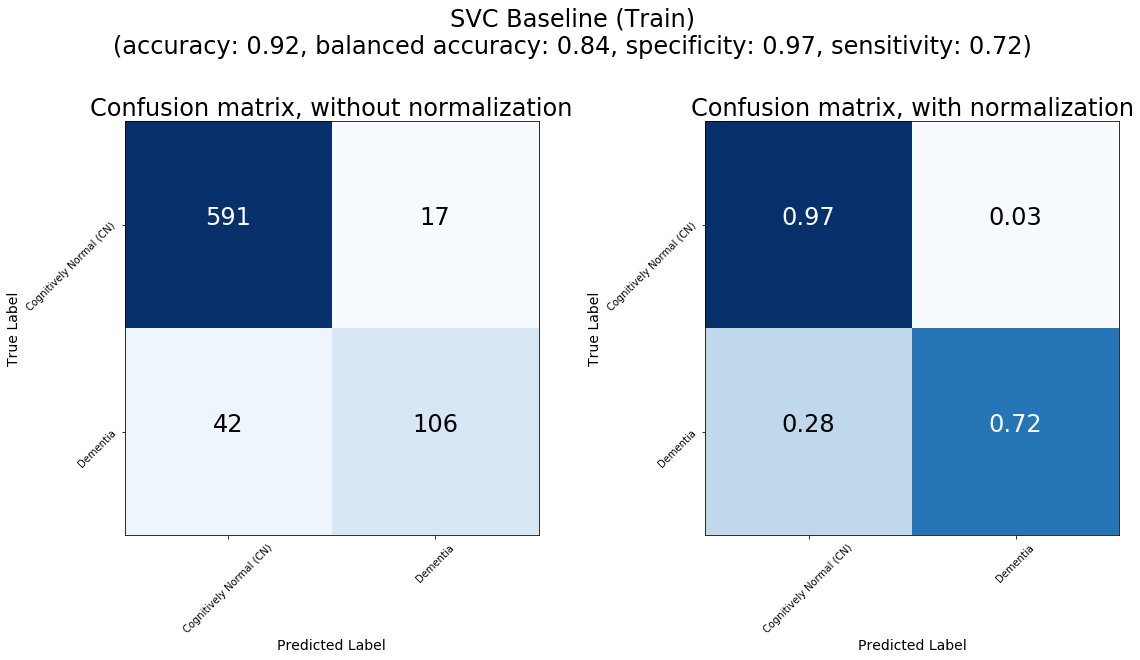

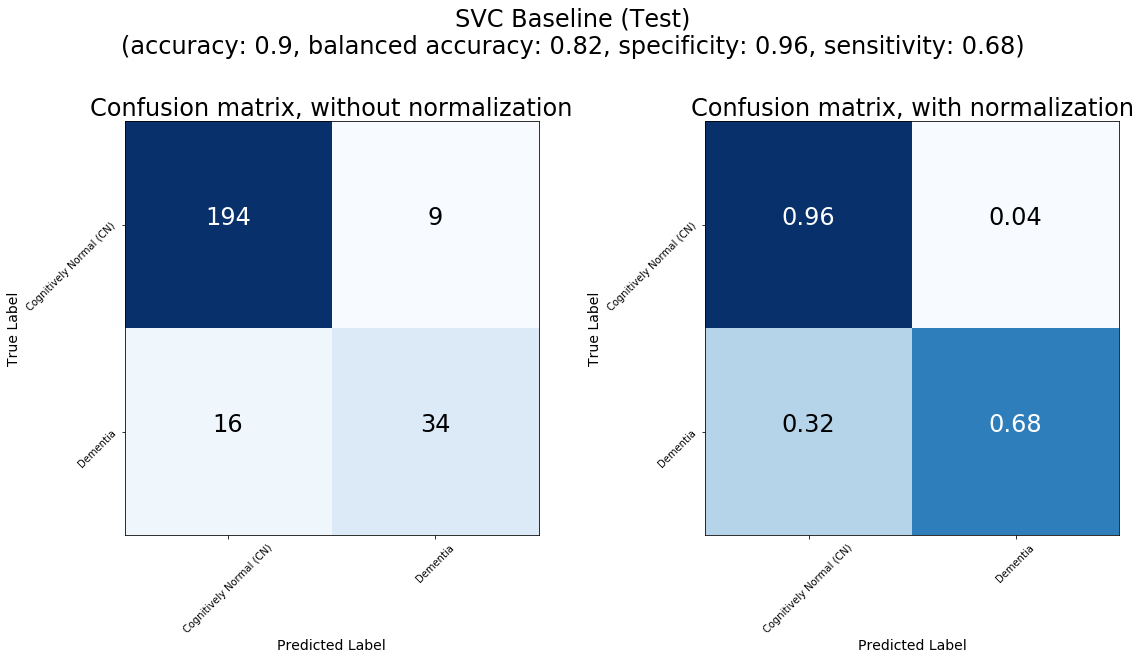

In [46]:
svc_baseline_model, svc_baseline_results_train, svc_baseline_results_test = \
    create_and_evaluate_model(
        GridSearchCV(
            SVC(),
            {
                "C": [100, 20, 10, 2, 1, 0.5, 0.1, 0.05, 0.01]
            },
            cv=3
        ).fit(X_train, y_train).best_estimator_,
        X_train,
        y_train,
        X_test, 
        y_test
    )
plot_model_results(svc_baseline_results_train, "SVC Baseline (Train)")
plot_model_results(svc_baseline_results_test, "SVC Baseline (Test)")

### Adjusting SVM with ROC

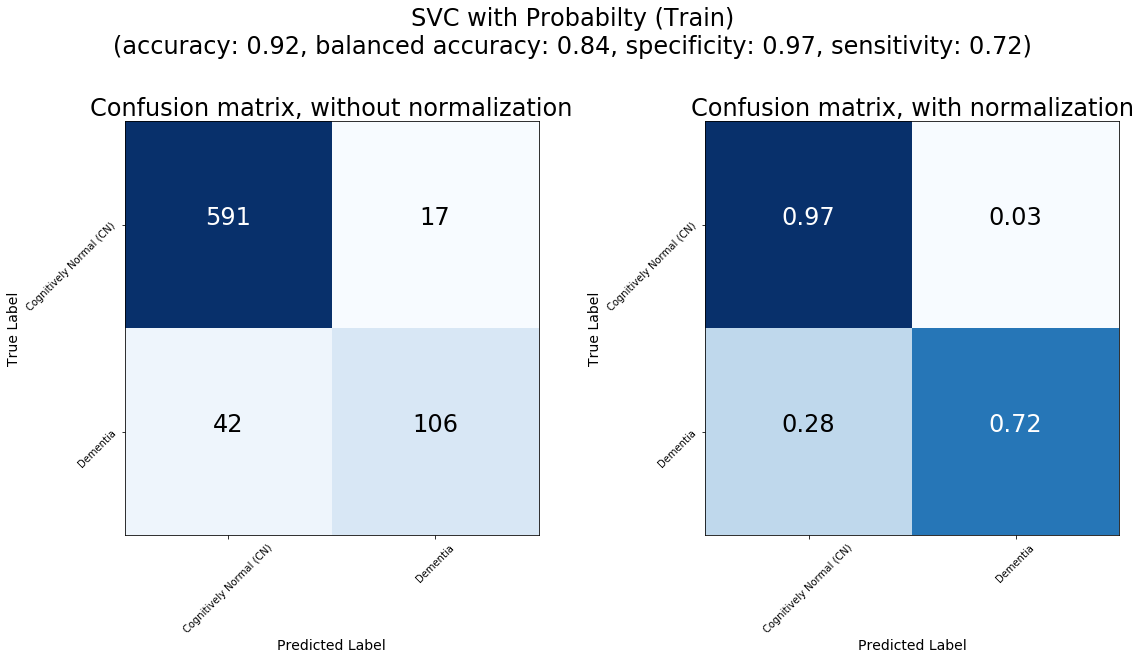

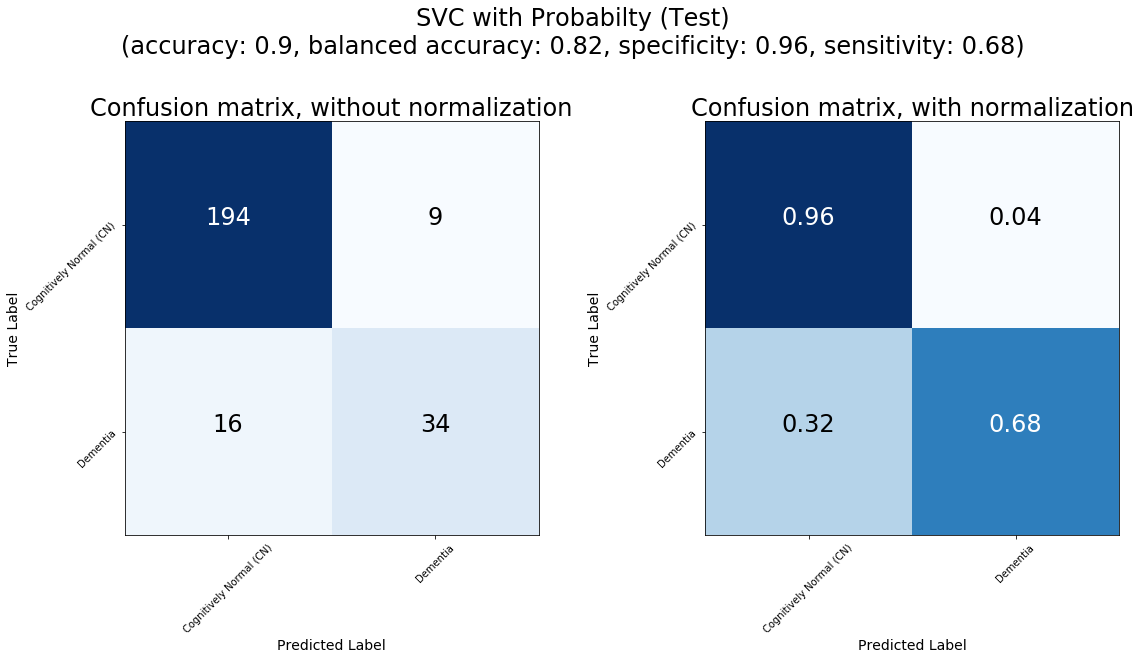

In [47]:
svc_probabilistic_model, svc_probabilistic_results_train, svc_probabilistic_results_test = \
    create_and_evaluate_model(
        GridSearchCV(
            SVC(probability=True),
            {
                "C": [100, 20, 10, 2, 1, 0.5, 0.1, 0.05, 0.01]
            },
            cv=3
        ).fit(X_train, y_train).best_estimator_,
        X_train,
        y_train,
        X_test, 
        y_test
    )
plot_model_results(svc_probabilistic_results_train, "SVC with Probabilty (Train)")
plot_model_results(svc_probabilistic_results_test, "SVC with Probabilty (Test)")

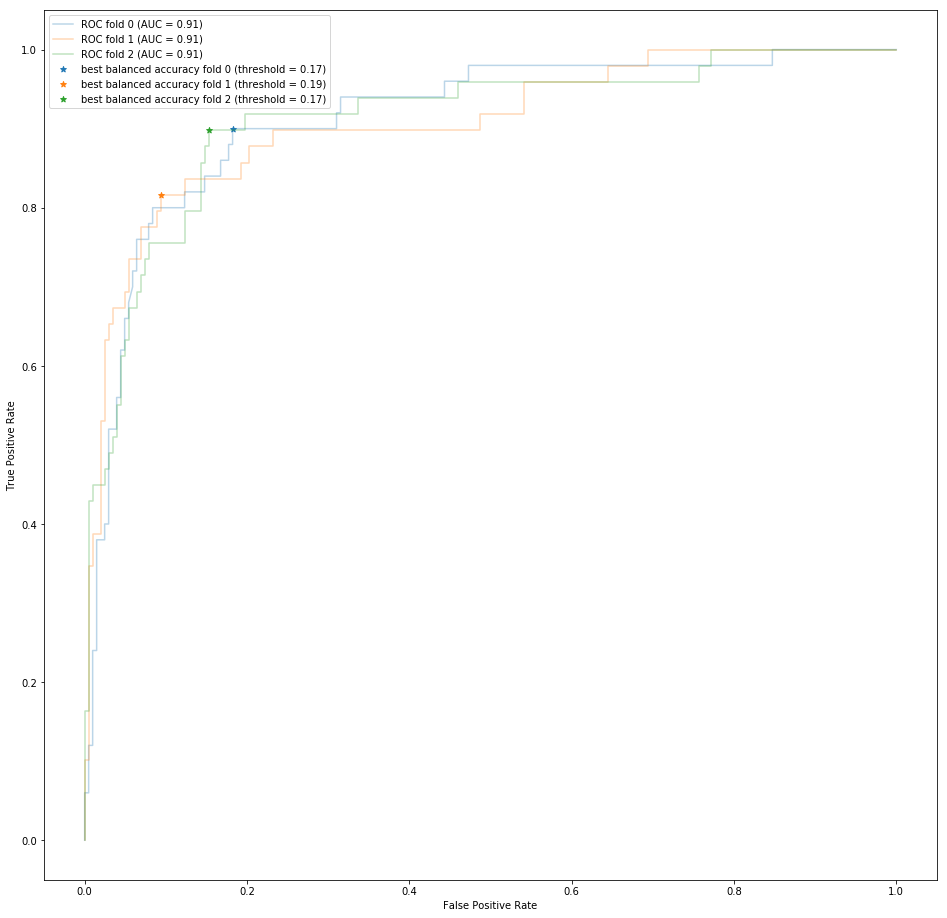

In [48]:
svc_probabilistic_augmented_roc_curves = augmented_roc_curves_cv(
    svc_probabilistic_model,
    X_train,
    y_train
)
svc_roc_tuned_threshold, _ = mean_threshold_best_balanced_accuracy(svc_probabilistic_augmented_roc_curves)
plot_augmented_roc_curves(svc_probabilistic_augmented_roc_curves)

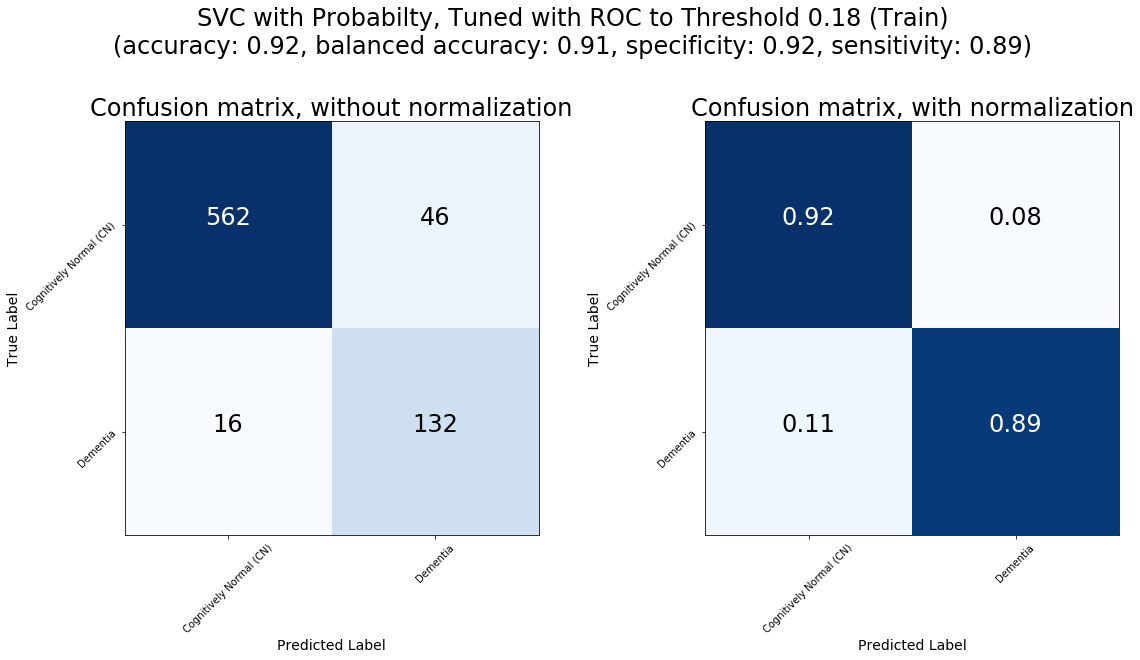

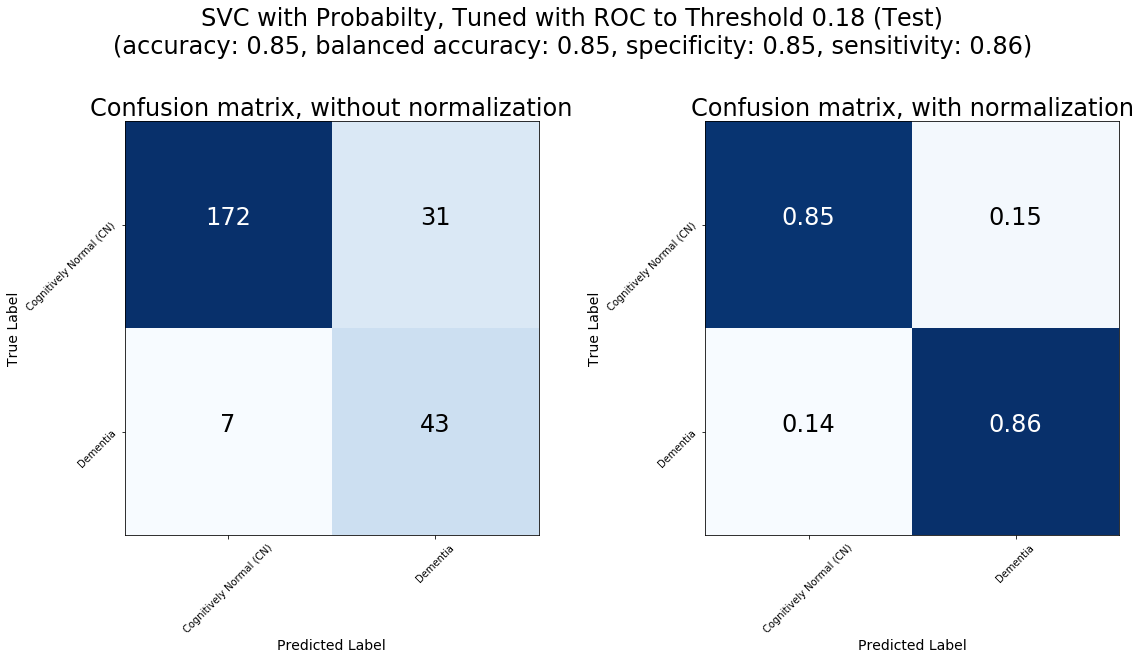

In [49]:
svc_roc_tuned_model, svc_roc_tuned_results_train, svc_roc_tuned_results_test = \
    create_and_evaluate_probabilistic_model(
        svc_probabilistic_model,
        X_train,
        y_train,
        X_test,
        y_test,
        svc_roc_tuned_threshold
    )
plot_model_results(
    svc_roc_tuned_results_train,
    f"SVC with Probabilty, Tuned with ROC to Threshold {svc_roc_tuned_threshold:.2} (Train)"
)
plot_model_results(
    svc_roc_tuned_results_test,
    f"SVC with Probabilty, Tuned with ROC to Threshold {svc_roc_tuned_threshold:.2} (Test)"
)

### Adjusting SVM with Class Weights

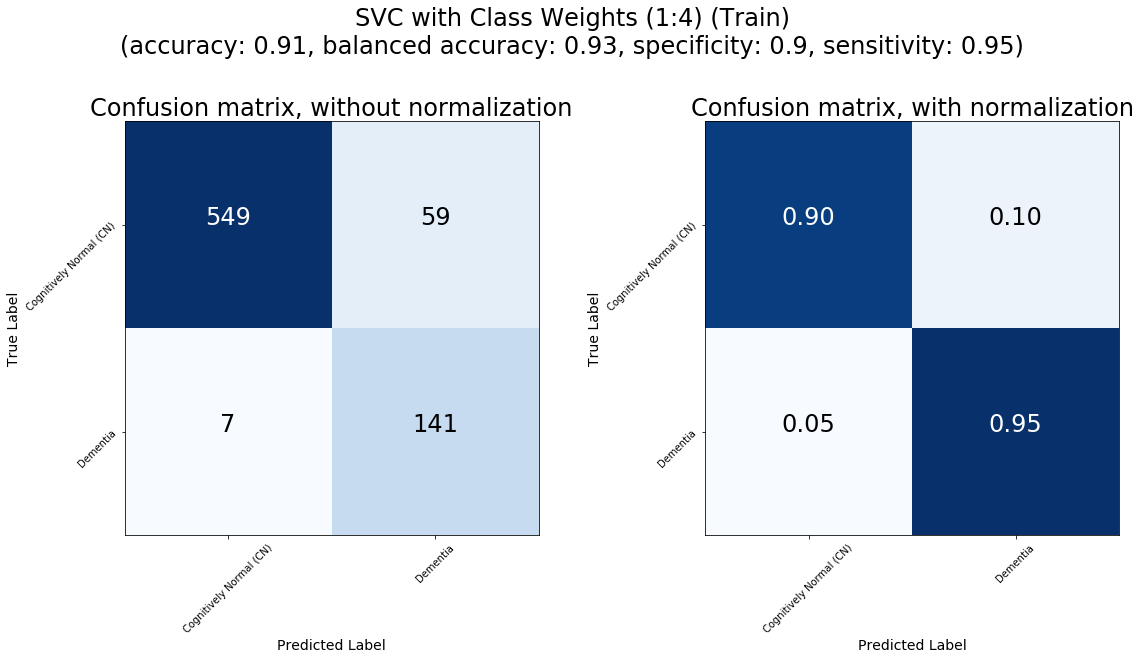

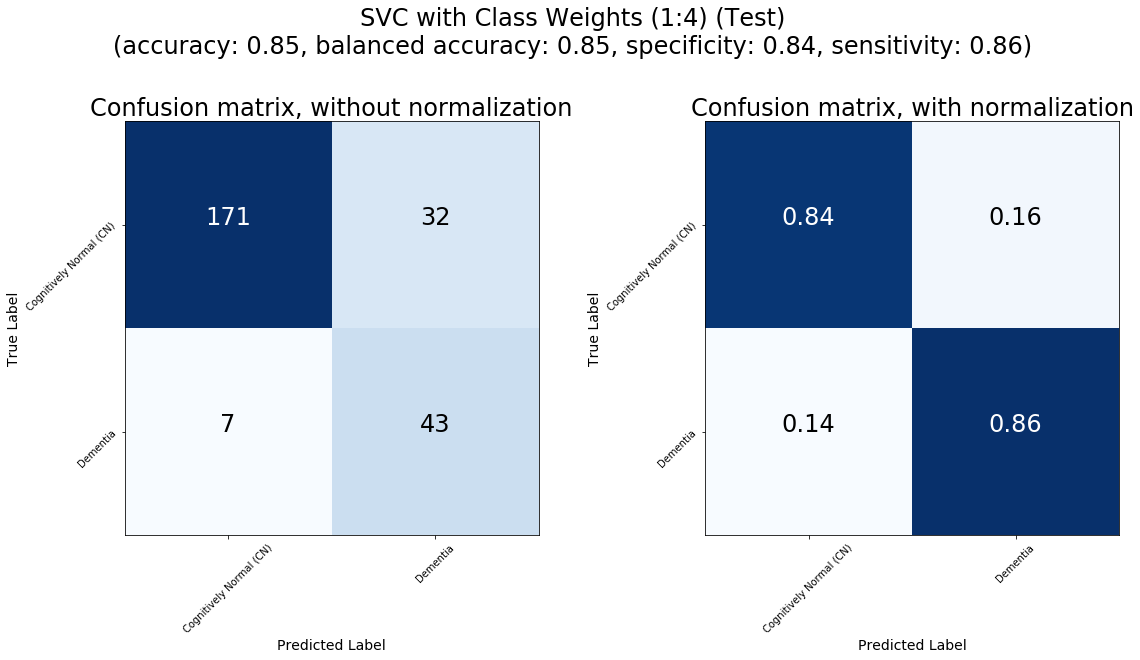

In [50]:
svc_weighted_model, svc_weighted_results_train, svc_weighted_results_test = \
    create_and_evaluate_model(
        GridSearchCV(
            SVC(class_weight={0: 1, 1: 4}),
            {
                "C": [100, 20, 10, 2, 1, 0.5, 0.1, 0.05, 0.01]
            },
            cv=3
        ).fit(X_train, y_train).best_estimator_,
        X_train,
        y_train,
        X_test,
        y_test
    )
plot_model_results(svc_weighted_results_train, "SVC with Class Weights (1:4) (Train)")
plot_model_results(svc_weighted_results_test, "SVC with Class Weights (1:4) (Test)")

### Random Forest

In [51]:
def rf_top_feature_counts(rf_model, columns):
    random_forest_top_feature_counts = \
        pd.Series(np.array([tree.tree_.feature[0] for tree in rf_model.estimators_])).value_counts()
    labeled_random_forest_top_feature_counts = \
        label_top_feature_counts(random_forest_top_feature_counts, columns)
    return labeled_random_forest_top_feature_counts
    
def label_top_feature_counts(top_feature_counts, columns):
    top_feature_count_labels = \
        top_feature_counts.index.to_series().apply(lambda i: columns[i])
    top_feature_counts = pd.concat(
        [top_feature_count_labels.rename("feature"), top_feature_counts.rename("count")],
        axis=1
    )
    return top_feature_counts.set_index("feature")

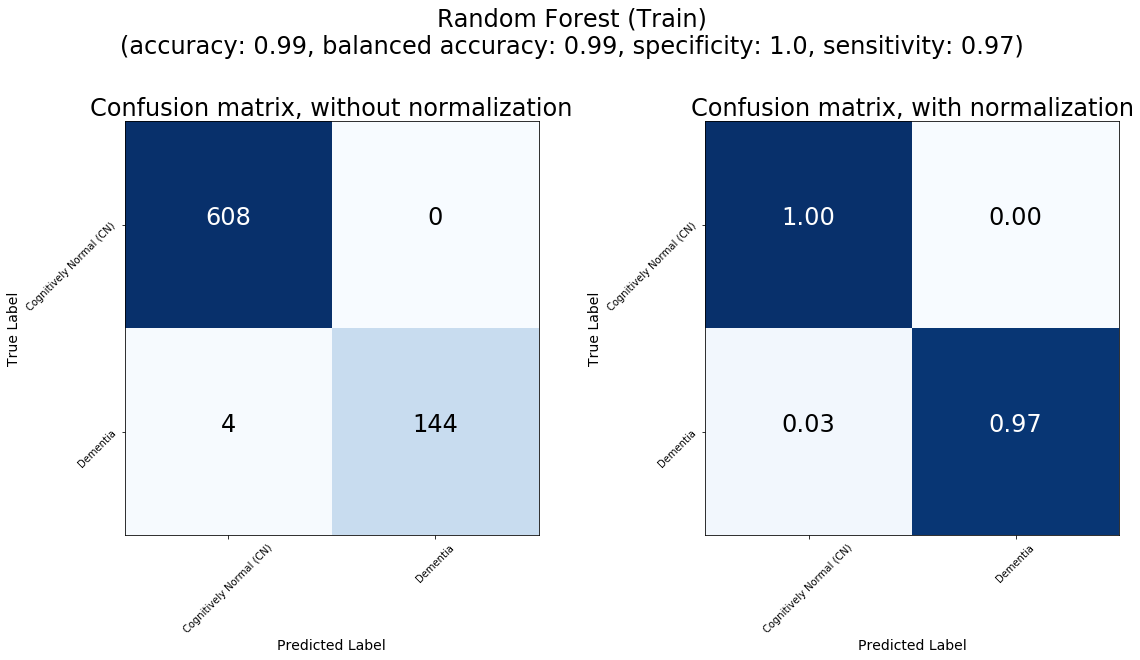

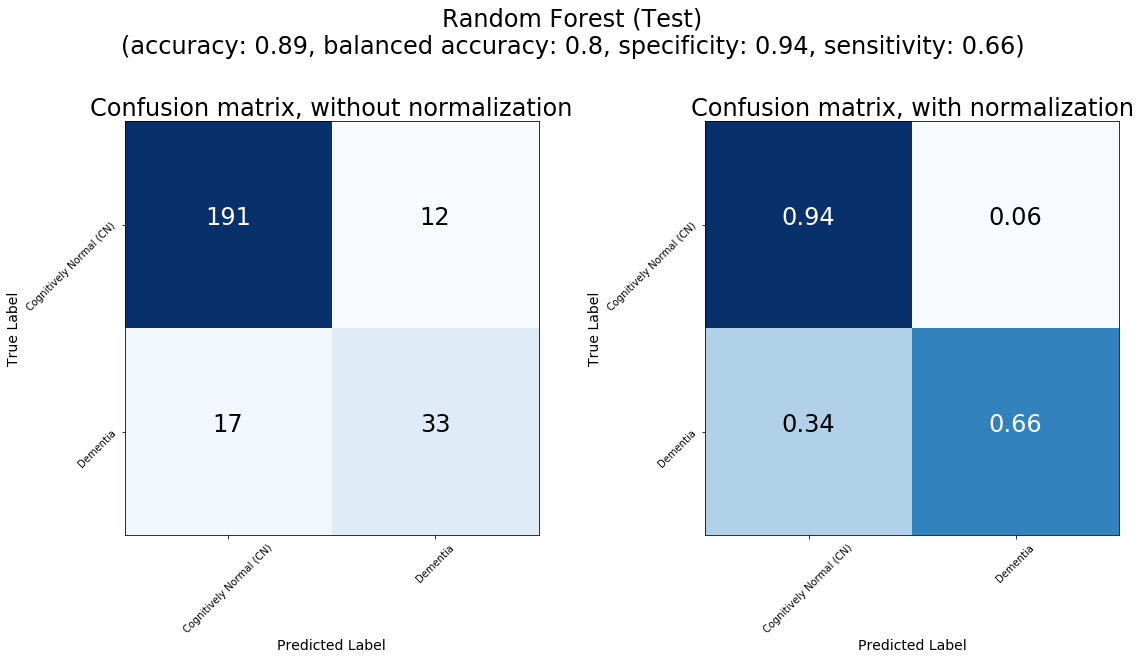

,count
feature,
FAQ,15
RAVLT_immediate,14
RAVLT_perc_forgetting,13
ADAS13,13
ADAS11,8
CDRSB,6
Hippocampus,6
MMSE,4
APOE4,4


In [52]:
rf_model, rf_results_train, rf_results_test = create_and_evaluate_model(
    GridSearchCV(
        RandomForestClassifier(n_estimators=100),
        {
            "max_depth": range(3, 20)
        },
        cv=3
    ).fit(X_train, y_train).best_estimator_,
    X_train,
    y_train,
    X_test,
    y_test
)
plot_model_results(rf_results_train, "Random Forest (Train)")
plot_model_results(rf_results_test, "Random Forest (Test)")
display(HTML("<h4>Top Feature Counts for Random Forest</h4>"))
display(rf_top_feature_counts(rf_model, X_train.columns))

### Adjusting Random Forest with ROC

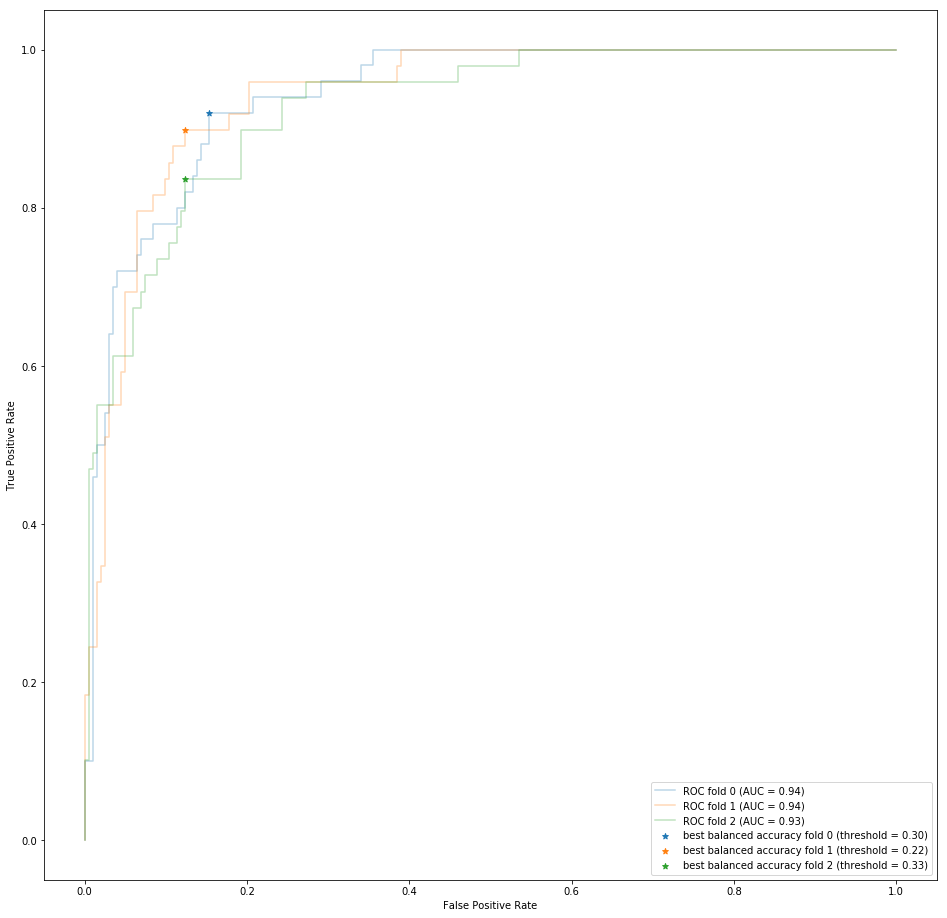

In [53]:
rf_augmented_roc_curves = augmented_roc_curves_cv(
    rf_model,
    X_train,
    y_train
)
rf_roc_tuned_threshold, _ = mean_threshold_best_balanced_accuracy(rf_augmented_roc_curves)
plot_augmented_roc_curves(rf_augmented_roc_curves)

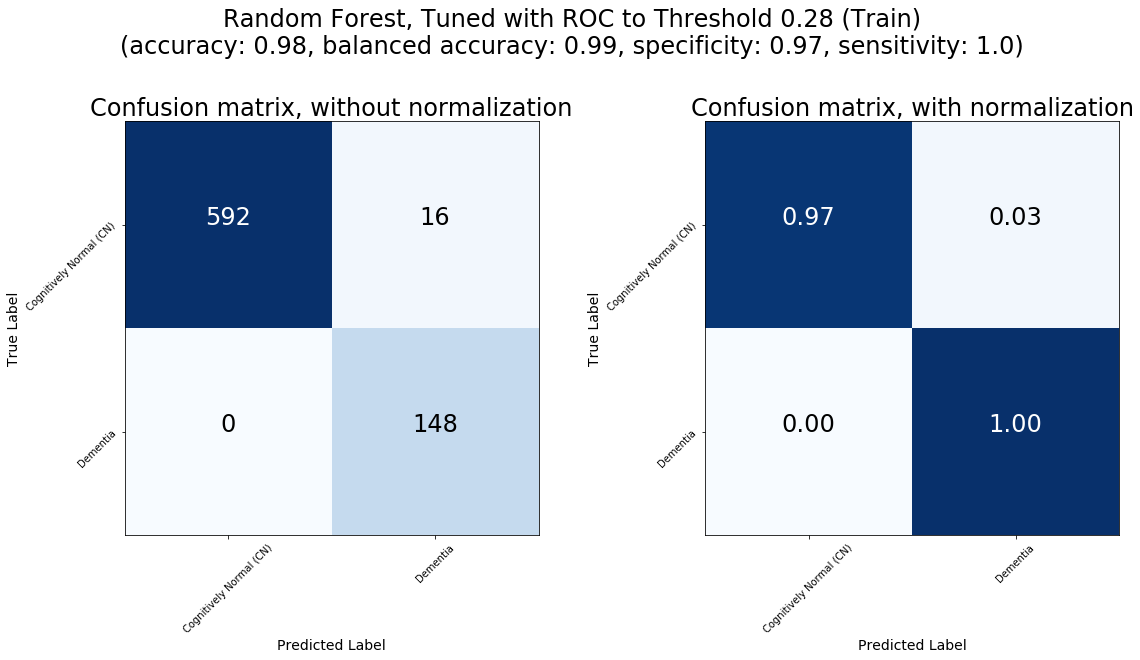

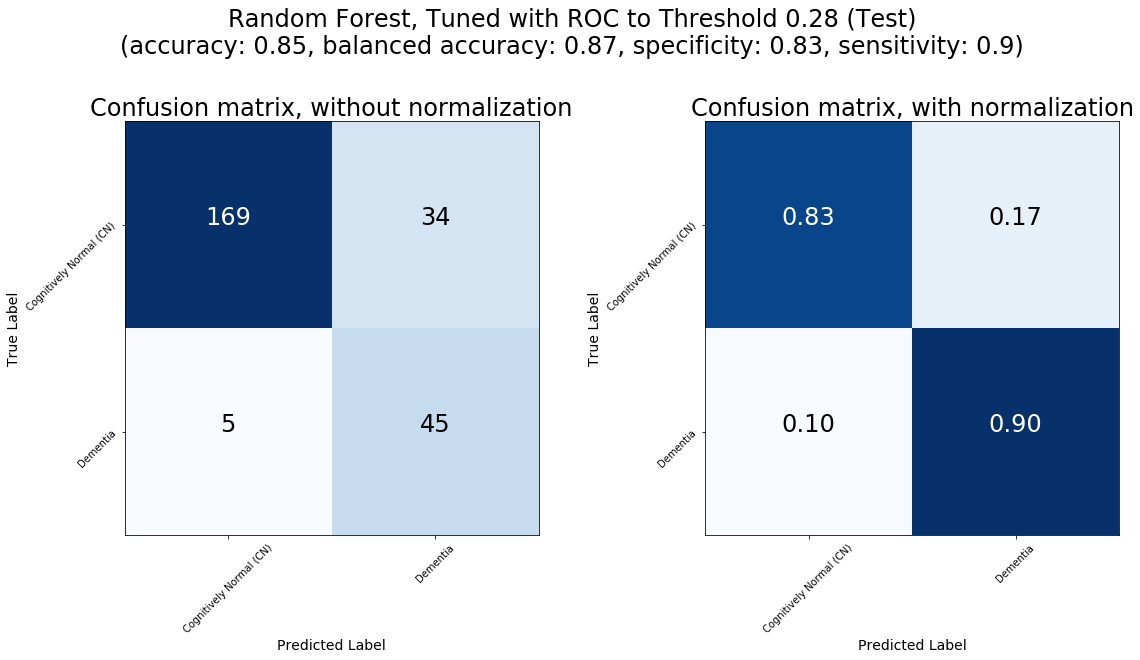

,count
feature,
FAQ,12
RAVLT_perc_forgetting,12
ADAS13,11
RAVLT_immediate,11
ADAS11,8
Entorhinal,7
Hippocampus,7
MMSE,6
RAVLT_learning,6


In [54]:
rf_roc_tuned_model, rf_roc_tuned_results_train, rf_roc_tuned_results_test = \
    create_and_evaluate_probabilistic_model(
        rf_model,
        X_train,
        y_train,
        X_test,
        y_test,
        rf_roc_tuned_threshold
    )
plot_model_results(
    rf_roc_tuned_results_train,
    f"Random Forest, Tuned with ROC to Threshold {rf_roc_tuned_threshold:.2} (Train)"
)
plot_model_results(
    rf_roc_tuned_results_test,
    f"Random Forest, Tuned with ROC to Threshold {rf_roc_tuned_threshold:.2} (Test)"
)
display(HTML(f"<h4>Top Feature Counts for Random Forest, Tuned with ROC to Threshold {rf_roc_tuned_threshold:.2}</h4>"))
display(rf_top_feature_counts(rf_roc_tuned_model, X_train.columns))

### Adjusting Random Forest with Class Weights

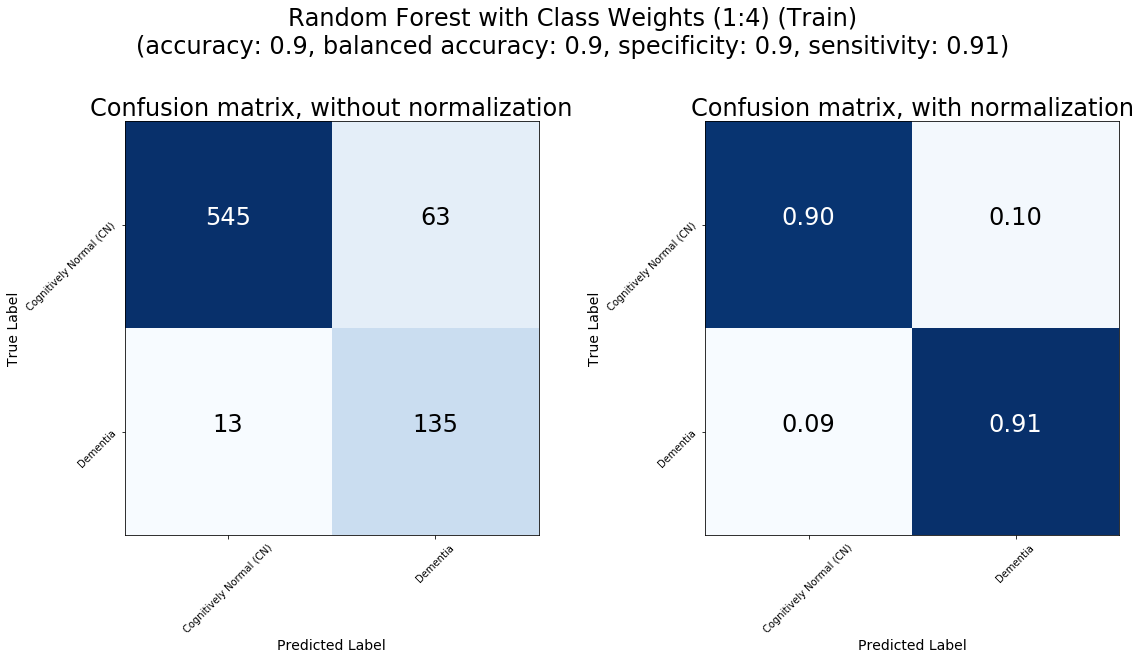

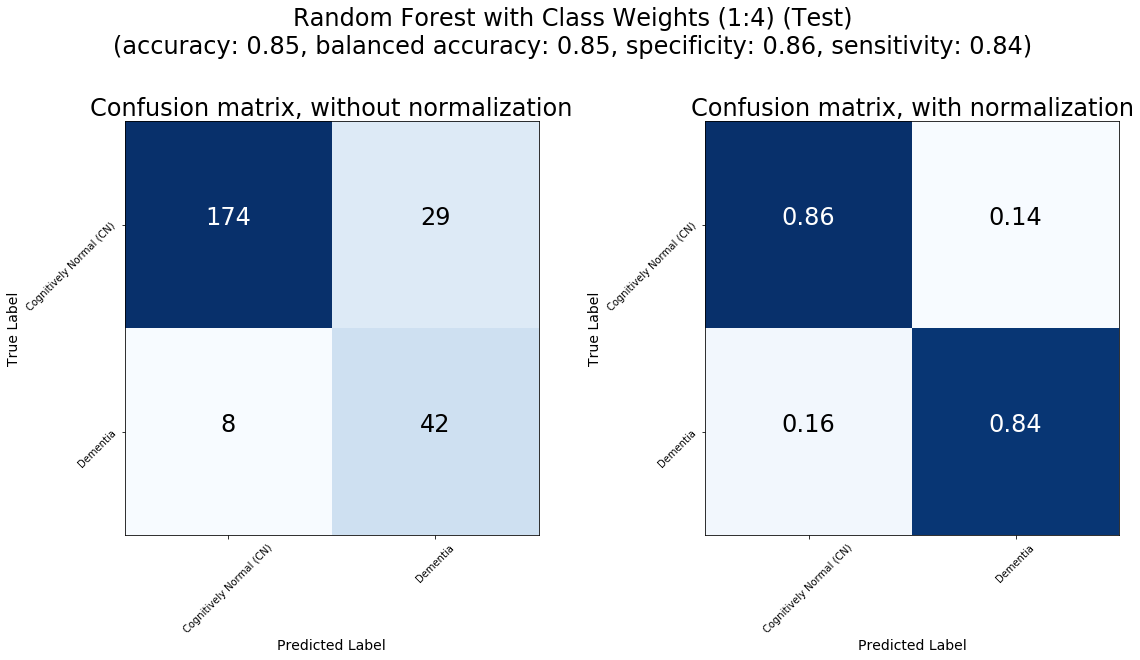

,count
feature,
RAVLT_immediate,19
ADAS13,17
ADAS11,13
FAQ,9
CDRSB,6
RAVLT_perc_forgetting,6
RAVLT_learning,5
Entorhinal,4
MMSE,4


In [55]:
rf_weighted_model, rf_weighted_results_train, rf_weighted_results_test = \
    create_and_evaluate_model(
        GridSearchCV(
            RandomForestClassifier(n_estimators=100, class_weight={0: 1, 1: 4}),
            {
                "max_depth": range(3, 20)
            },
            scoring="balanced_accuracy",
            cv=3
        ).fit(X_train, y_train).best_estimator_,
        X_train,
        y_train,
        X_test,
        y_test
    )
plot_model_results(rf_weighted_results_train, "Random Forest with Class Weights (1:4) (Train)")
plot_model_results(rf_weighted_results_test, "Random Forest with Class Weights (1:4) (Test)")
display(HTML(f"<h4>Top Feature Counts for Random Forest with Class Weights (1:4)</h4>"))
display(rf_top_feature_counts(rf_weighted_model, X_train.columns))

### Logistic Regression

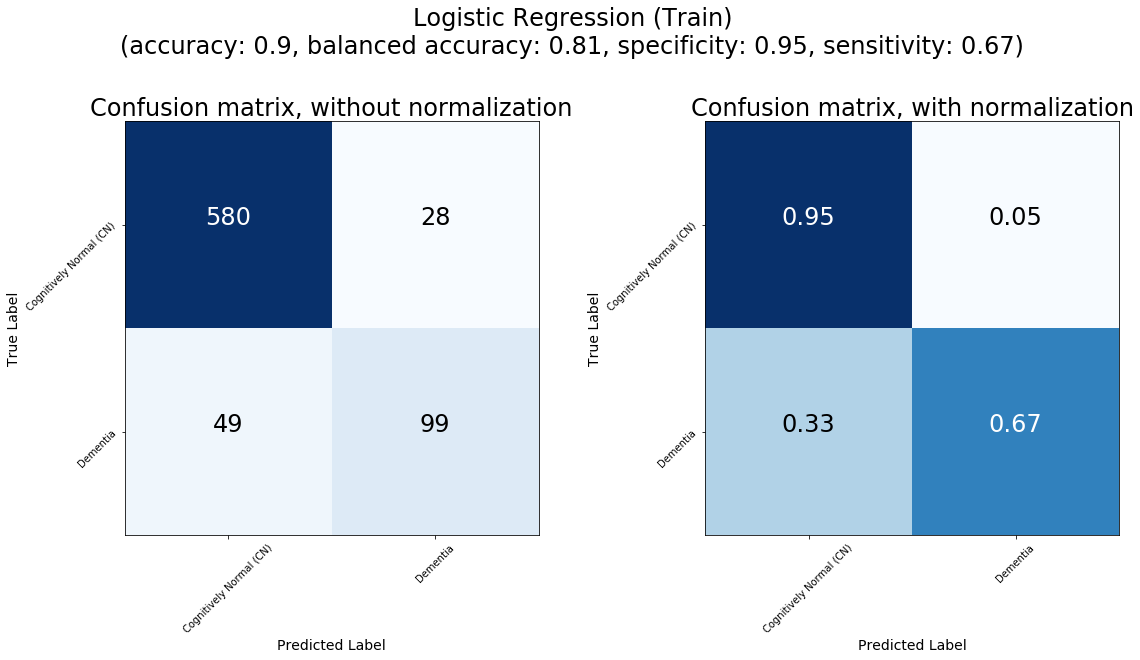

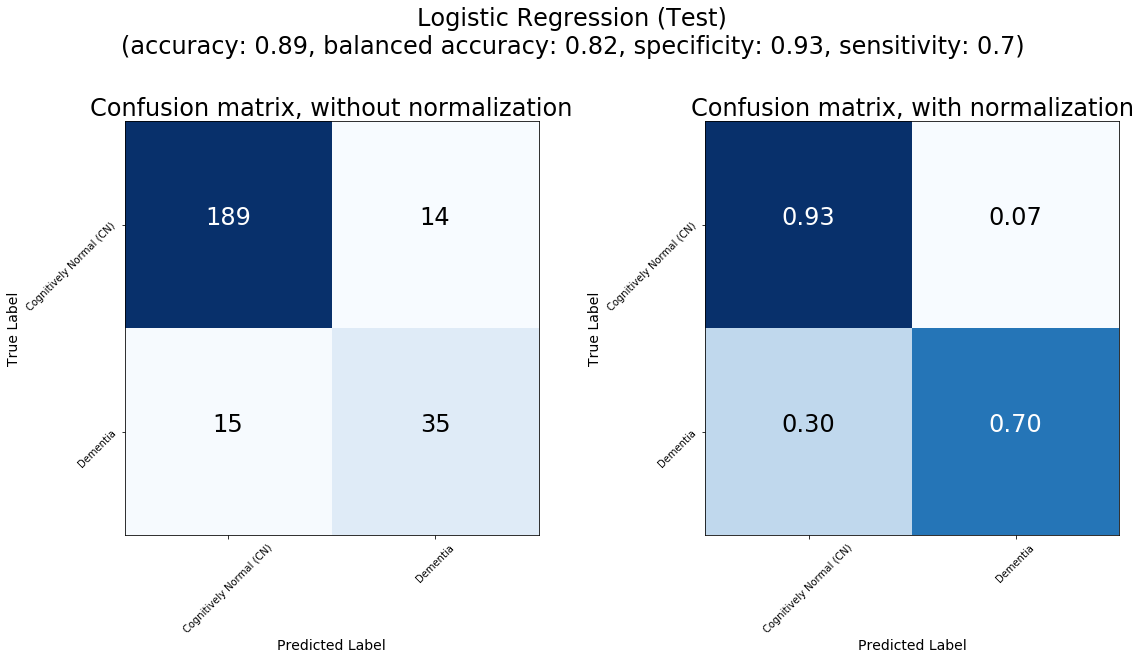

In [56]:
logreg_model, logreg_results_train, logreg_results_test = create_and_evaluate_model(
    LogisticRegressionCV(max_iter=1000).fit(X_train, y_train),
    X_train,
    y_train,
    X_test,
    y_test
)
plot_model_results(logreg_results_train, "Logistic Regression (Train)")
plot_model_results(logreg_results_test, "Logistic Regression (Test)")

### Adjusting Logistic Regression with ROC

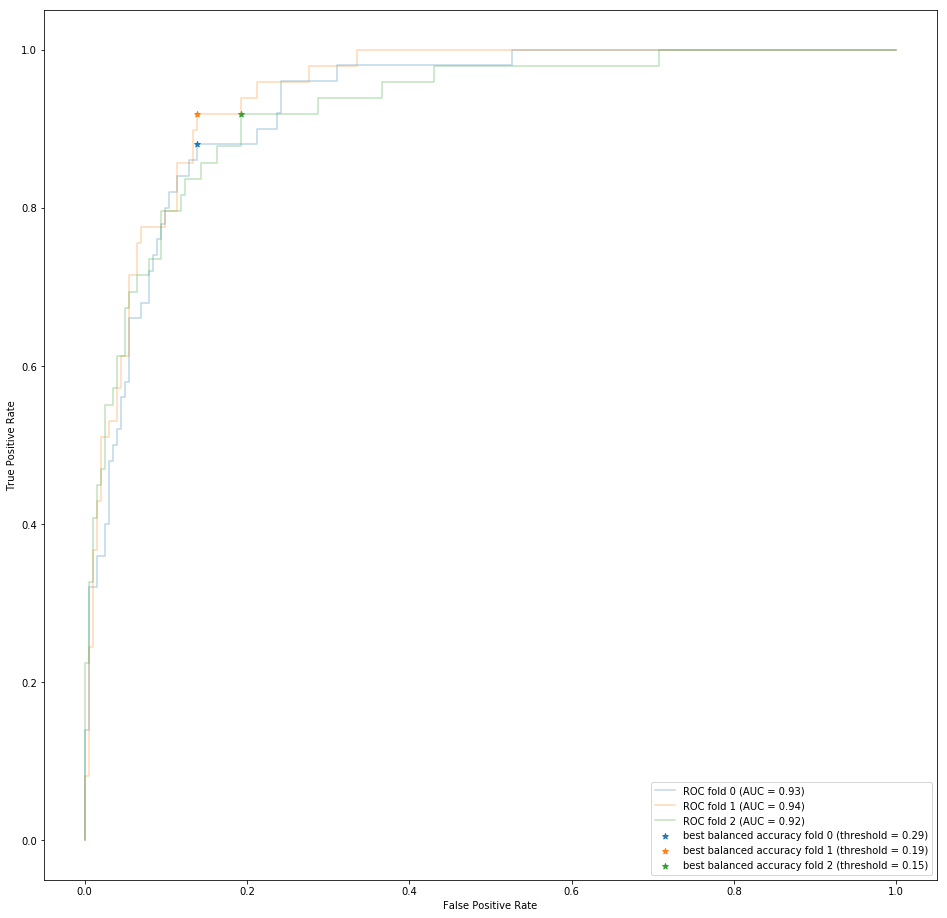

In [57]:
logreg_augmented_roc_curves = augmented_roc_curves_cv(
    logreg_model,
    X_train,
    y_train
)
logreg_roc_tuned_threshold, _ = mean_threshold_best_balanced_accuracy(logreg_augmented_roc_curves)
plot_augmented_roc_curves(logreg_augmented_roc_curves)

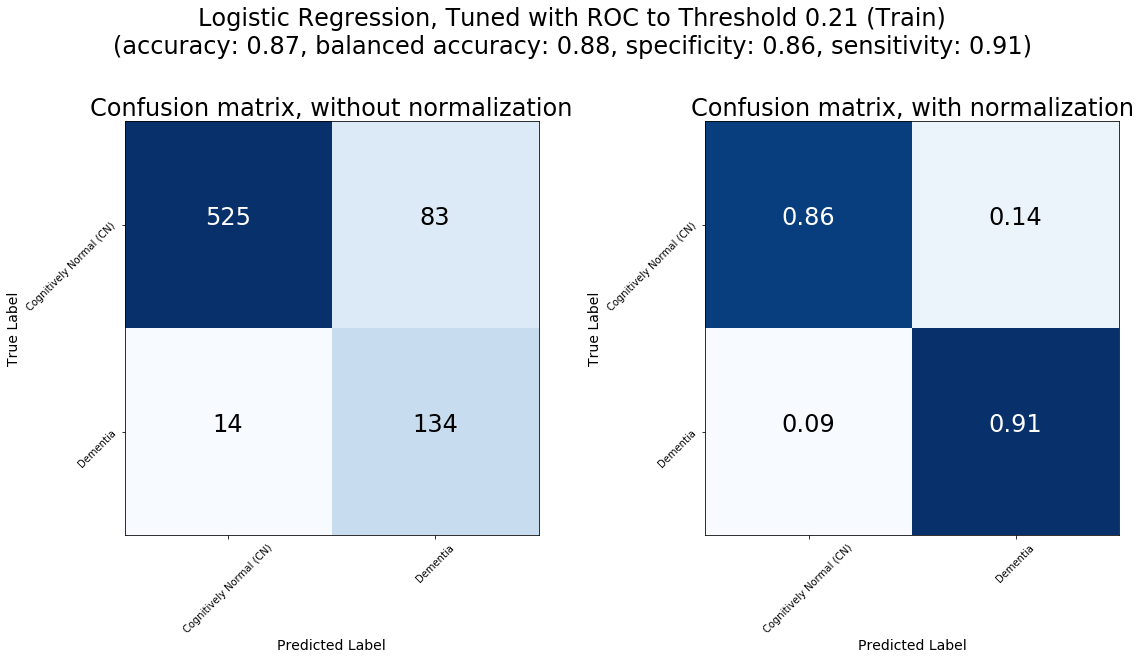

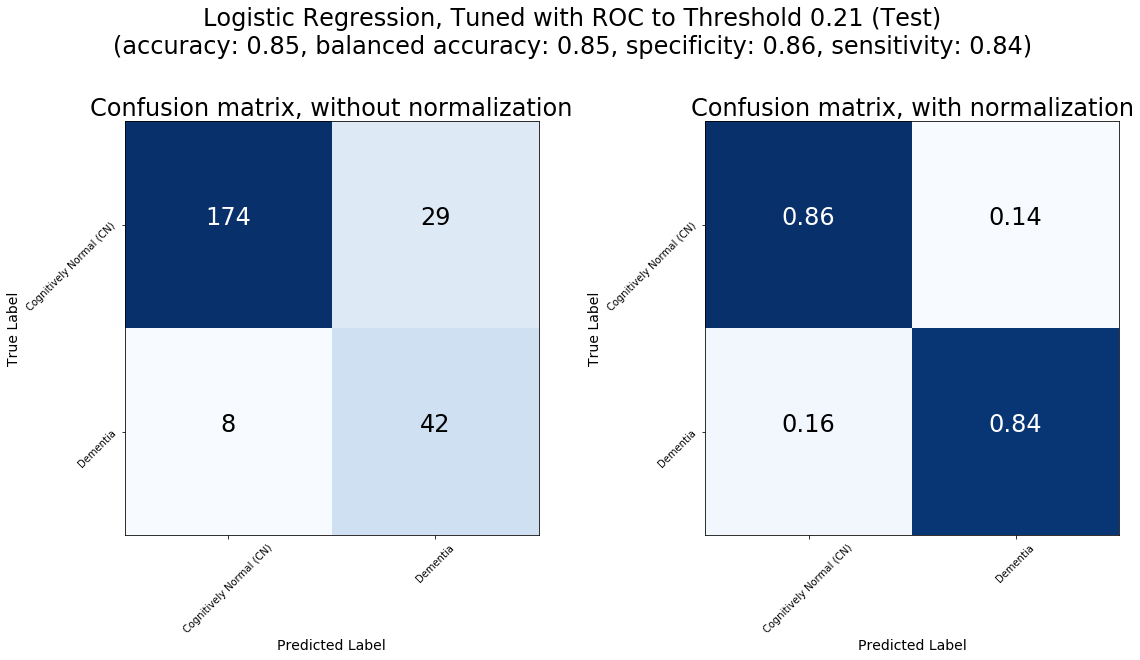

In [58]:
logreg_roc_tuned_model, logreg_roc_tuned_results_train, logreg_roc_tuned_results_test = \
    create_and_evaluate_probabilistic_model(
        logreg_model,
        X_train,
        y_train,
        X_test,
        y_test,
        logreg_roc_tuned_threshold
    )
plot_model_results(
    logreg_roc_tuned_results_train,
    f"Logistic Regression, Tuned with ROC to Threshold {logreg_roc_tuned_threshold:.2} (Train)"
)
plot_model_results(
    logreg_roc_tuned_results_test,
    f"Logistic Regression, Tuned with ROC to Threshold {logreg_roc_tuned_threshold:.2} (Test)"
)

### Adjusting Logistic Regression with Class Weights

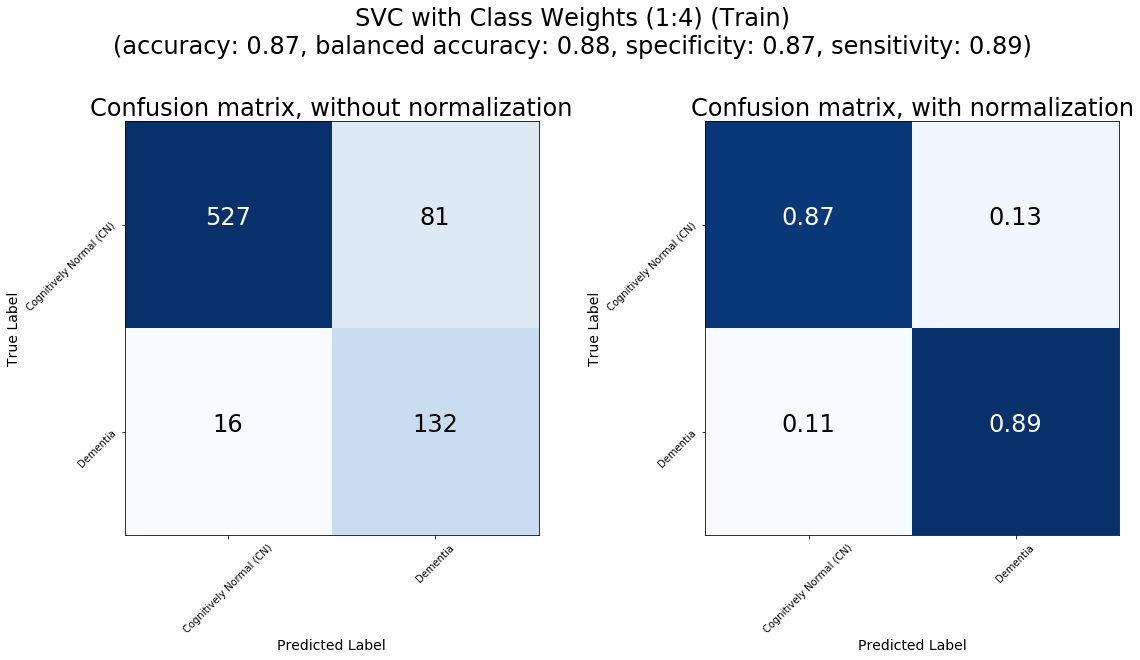

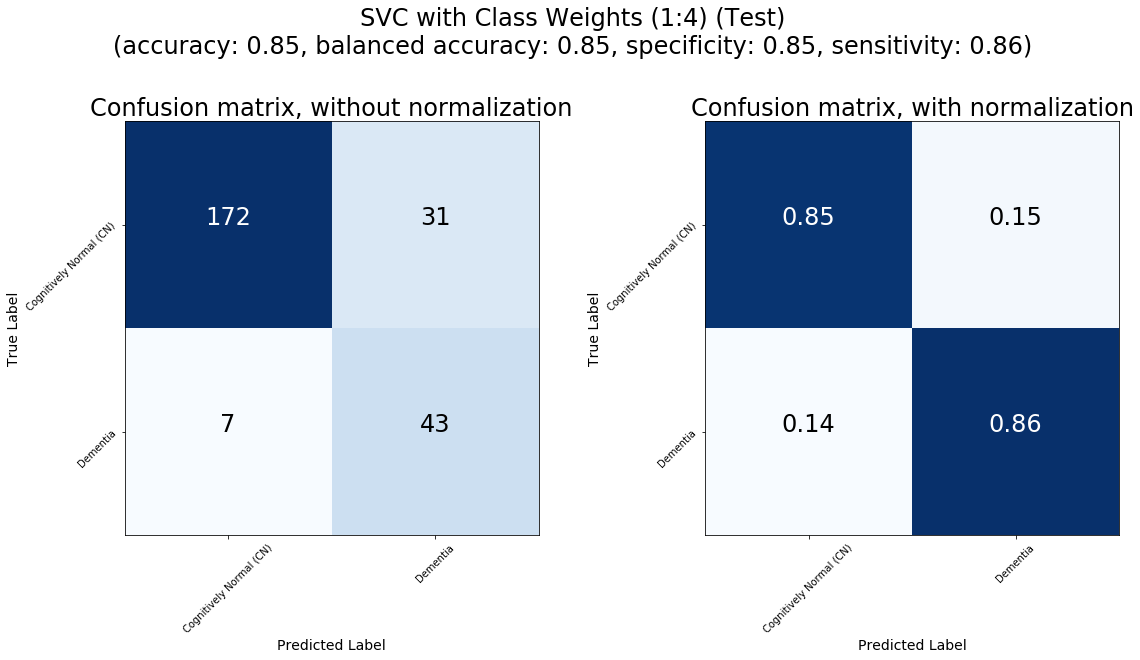

In [59]:
logreg_weighted_model, logreg_weighted_results_train, logreg_weighted_results_test = \
    create_and_evaluate_model(
        LogisticRegressionCV(
            max_iter=1000,
            class_weight={0: 1, 1: 4},
            scoring="balanced_accuracy"
        ).fit(X_train, y_train),
        X_train,
        y_train,
        X_test,
        y_test
    )
plot_model_results(logreg_weighted_results_train, "SVC with Class Weights (1:4) (Train)")
plot_model_results(logreg_weighted_results_test, "SVC with Class Weights (1:4) (Test)")

## Summary

In [60]:
train_results = pd.DataFrame(
    list(map(
        model_results_to_dict,
        *zip(*[
            (svc_baseline_results_train, "SVC"),
            (svc_probabilistic_results_train, "SVC with Probability Outputs"),
            (rf_results_train, "Random Forest"),
            (logreg_results_train, "Logistic Regression"),
            (svc_roc_tuned_results_train, "SVC Tuned with ROC"),
            (rf_roc_tuned_results_train, "Random Forest Tuned with ROC"),
            (logreg_roc_tuned_results_train, "Logistic Regression Tuned with ROC"),
            (svc_weighted_results_train, "SVC with Class Weights"),
            (rf_weighted_results_train, "Random Forest with Class Weights"),
            (logreg_weighted_results_train, "Logistic Regression with Class Weights")
        ])
    )),
    columns=["model", "accuracy", "specificity", "sensitivity", "balanced accuracy"]
).set_index("model")

with pd.option_context("precision", 3):
    display(HTML("<h3>Model Performance on Training Data</h3>"))
    print(train_results.to_string())

                                        accuracy  specificity  sensitivity  balanced accuracy
model                                                                                        
SVC                                        0.922        0.972        0.716              0.844
SVC with Probability Outputs               0.922        0.972        0.716              0.844
Random Forest                              0.995        1.000        0.973              0.986
Logistic Regression                        0.898        0.954        0.669              0.811
SVC Tuned with ROC                         0.918        0.924        0.892              0.908
Random Forest Tuned with ROC               0.979        0.974        1.000              0.987
Logistic Regression Tuned with ROC         0.872        0.863        0.905              0.884
SVC with Class Weights                     0.913        0.903        0.953              0.928
Random Forest with Class Weights           0.899        0.89

In [61]:
test_results = pd.DataFrame(
    list(map(
        model_results_to_dict,
        *zip(*[
            (svc_baseline_results_test, "SVC"),
            (svc_probabilistic_results_test, "SVC with Probability Outputs"),
            (rf_results_test, "Random Forest"),
            (logreg_results_test, "Logistic Regression"),
            (svc_roc_tuned_results_test, "SVC Tuned with ROC"),
            (rf_roc_tuned_results_test, "Random Forest Tuned with ROC"),
            (logreg_roc_tuned_results_test, "Logistic Regression Tuned with ROC"),
            (svc_weighted_results_test, "SVC with Class Weights"),
            (rf_weighted_results_test, "Random Forest with Class Weights"),
            (logreg_weighted_results_test, "Logistic Regression with Class Weights")
        ])
    )),
    columns=["model", "accuracy", "specificity", "sensitivity", "balanced accuracy"]
).set_index("model")

with pd.option_context("precision", 3):
    display(HTML("<h3>Model Performance on Test Data</h3>"))
    print(test_results.to_string())

                                        accuracy  specificity  sensitivity  balanced accuracy
model                                                                                        
SVC                                        0.901        0.956         0.68              0.818
SVC with Probability Outputs               0.901        0.956         0.68              0.818
Random Forest                              0.885        0.941         0.66              0.800
Logistic Regression                        0.885        0.931         0.70              0.816
SVC Tuned with ROC                         0.850        0.847         0.86              0.854
Random Forest Tuned with ROC               0.846        0.833         0.90              0.866
Logistic Regression Tuned with ROC         0.854        0.857         0.84              0.849
SVC with Class Weights                     0.846        0.842         0.86              0.851
Random Forest with Class Weights           0.854        0.85